In [14]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from windrose import WindAxes
from windrose import WindroseAxes
import matplotlib.dates as mdates
from scipy.stats import norm
from scipy.stats import weibull_min

In [15]:
# Extraindo o diretório que estamos trabalhando

cwd = os.getcwd()
print('Diretório atual: ' + cwd)

# Estabelecendo a pasta de dados que quero utilizar
dataPath = os.path.dirname(cwd) + '\\ENS410064\\dados_trabalho'
print('Diretório de dados: ' + dataPath)

Diretório atual: c:\Users\alysson.assis\OneDrive - ARAXA\Documentos\Tópicos especiais-Python in Environmental Applications\ENS410064
Diretório de dados: c:\Users\alysson.assis\OneDrive - ARAXA\Documentos\Tópicos especiais-Python in Environmental Applications\ENS410064\dados_trabalho


In [16]:
# Listando arquivos com o nome iniciando em metar

prefixed = [filename for filename in os.listdir(dataPath) if filename.startswith("metar_SBFL")]

dataList = prefixed

print(prefixed)

['metar_SBFL_2013.csv', 'metar_SBFL_2014.csv', 'metar_SBFL_2015.csv', 'metar_SBFL_2016.csv', 'metar_SBFL_2017.csv', 'metar_SBFL_2018.csv', 'metar_SBFL_2019.csv', 'metar_SBFL_2020.csv', 'metar_SBFL_2021.csv', 'metar_SBFL_2022.csv', 'metar_SBFL_2023.csv']


In [17]:
# Extraindo os anos dos dados

years = []
for dl in dataList:
    if os.path.isfile(dataPath+'\\'+dl):
        years.append(dl.split('_')[-1].split('.')[0])
    else:
        print('Não é um arquivo')

years = np.unique(years)
print(years)

['2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022'
 '2023']


In [18]:
# Lendo todos os arquivos da pasta

dataAll=[]
for dl in dataList:
    print(dl)
    data = pd.read_csv(dataPath+'\\'+dl)
    dataAll.append(data)

# Concatenando a lista de dados

dataAll = pd.concat(dataAll)
dataAll.head()

metar_SBFL_2013.csv
metar_SBFL_2014.csv
metar_SBFL_2015.csv
metar_SBFL_2016.csv
metar_SBFL_2017.csv
metar_SBFL_2018.csv
metar_SBFL_2019.csv
metar_SBFL_2020.csv
metar_SBFL_2021.csv
metar_SBFL_2022.csv
metar_SBFL_2023.csv


,day,month,year,hour,ct,wd,ws,hc,ccp,cco,p,temp,dpTemp,vis,pw,relh
0,1,1,2013,0,NaN,10.0,7.202216,365.76,3.0,3.0,1009.678792,26.0,24.0,NaN,0.0,88.75
1,1,1,2013,1,NaN,320.0,5.658884,365.76,3.0,3.0,1009.675199,26.0,23.0,NaN,0.0,83.55
2,1,1,2013,2,NaN,330.0,7.202216,365.76,3.0,3.0,1009.675199,26.0,23.0,NaN,0.0,83.55
3,1,1,2013,3,NaN,330.0,7.716660,365.76,3.0,3.0,1009.678792,26.0,23.0,NaN,0.0,83.55
4,1,1,2013,4,NaN,330.0,4.629996,365.76,3.0,3.0,1009.682386,25.0,23.0,NaN,0.0,88.67


In [19]:
# Separando dados que serão trabalhados

df_filtrado = dataAll[['month', 'year','day','hour','wd','ws']]

df_filtrado.head()
df_filtrado.shape

(96139, 6)

In [20]:
# Limpeza dos dados

# Contando valores de ws nulos
num_nulos=df_filtrado.ws.isnull().sum()
print("número de valores nulos=", num_nulos)

# Contando valores de ws zero
num_zeros = (df_filtrado.ws == 0).sum()
print("número de valores iguais a zero= ", num_zeros)

# Tornando todas as colunas NaN nas linhas onde a coluna 'ws' tem valores nulos
df_filtrado.loc[df_filtrado['ws'].isnull(), :] = np.nan

# Tornando todas as colunas NaN nas linhas onde a coluna 'ws' tem valor zero
df_filtrado.loc[df_filtrado['ws'] == 0, :] = np.nan

# Excluindo todas as linhas que contêm valores NaN
df_sem_nan = df_filtrado.dropna()

df_filtrado = df_sem_nan

# Criando uma coluna datetime no meu dataframe
df_filtrado['datetime'] = pd.to_datetime(df_filtrado[['year','month','day','hour']])

# Verificando tamanho da variável dataAll com e sem repetições
print('\n','Este é o tamanho original')
print(df_filtrado.shape)
print('')

print('Este é o tamanho sem repetições de datas')
print(df_filtrado['datetime'].unique().shape)

# Criando dataframe sem repetições
df_filtrado = df_filtrado.drop_duplicates(subset='datetime', keep="first")

# Estabelecendo o índice do dataframe como datetime
df_filtrado = df_filtrado.set_index('datetime')

número de valores nulos= 17
número de valores iguais a zero=  4790

 Este é o tamanho original
(89955, 7)

Este é o tamanho sem repetições de datas
(89955,)


In [21]:
#Estatísticas

# Máximo valor de ws
print("ws máximo= ", df_filtrado.ws.max())

# Estabelecendo o índice do dataframe como wd
df_filtrado2 = df_filtrado.set_index('wd')

# Encontrando a data de ocorrência do valor máximo'
indice_maximo = df_filtrado['ws'].idxmax()
print(f"A data do valor máximo de velocidade do vento ws, em m/s, foi: {indice_maximo}")

# Encontrando a direção de ocorrência do valor máximo'
indice_maximo_dir = df_filtrado2['ws'].idxmax()
print(f"A direção do valor máximo de velocidade do vento ws, em m/s, foi: {indice_maximo_dir} graus")

# Calculando a média mensal da coluna 'ws'
media_mensal_ws = df_filtrado['ws'].resample('M').mean()
print("\n",f"média mensal: {media_mensal_ws}")

# Calculando a máxima mensal da coluna 'ws'
maxima_mensal_ws = df_filtrado['ws'].resample('M').max()
print("\n",f"máxima mensal: {maxima_mensal_ws}")


ws máximo=  29.837752
A data do valor máximo de velocidade do vento ws, em m/s, foi: 2015-02-08 02:00:00
A direção do valor máximo de velocidade do vento ws, em m/s, foi: 130.0 graus

 média mensal: datetime
2013-01-31    4.028864
2013-02-28    3.637257
2013-03-31    3.674930
2013-04-30    3.098913
2013-05-31    3.421053
                ...   
2023-08-31    4.371759
2023-09-30    4.329406
2023-10-31    3.850044
2023-11-30    4.172296
2023-12-31    4.424362
Freq: ME, Name: ws, Length: 132, dtype: float64

 máxima mensal: datetime
2013-01-31    10.803324
2013-02-28    11.574990
2013-03-31    21.863870
2013-04-30     9.259992
2013-05-31    10.803324
                ...    
2023-08-31    13.118322
2023-09-30    11.832212
2023-10-31     9.517214
2023-11-30    18.005540
2023-12-31    10.288880
Freq: ME, Name: ws, Length: 132, dtype: float64


C:\Users\alysson.assis\AppData\Local\Temp\ipykernel_20156\2348997243.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  media_mensal_ws = df_filtrado['ws'].resample('M').mean()
C:\Users\alysson.assis\AppData\Local\Temp\ipykernel_20156\2348997243.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  maxima_mensal_ws = df_filtrado['ws'].resample('M').max()


(np.int64(0), np.int64(8778))

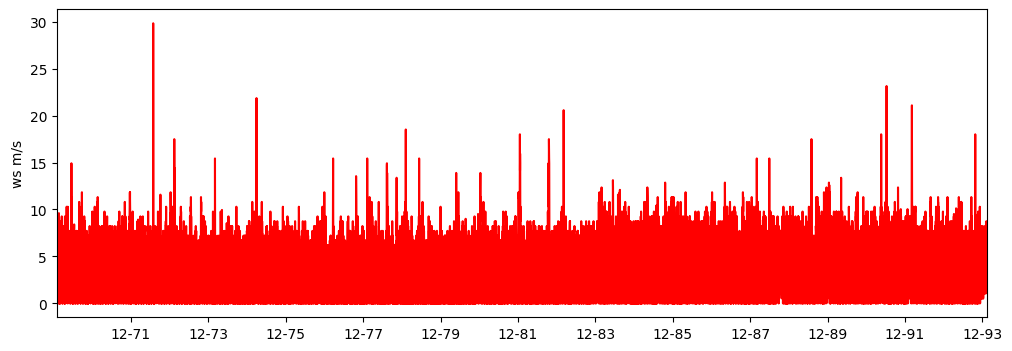

In [22]:
# Criando gráfico de linhas da série total

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataAll.ws,color='red')
ax.set_ylabel('ws m/s')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax.set_xlim([dataAll.index.min(),dataAll.index.max()])

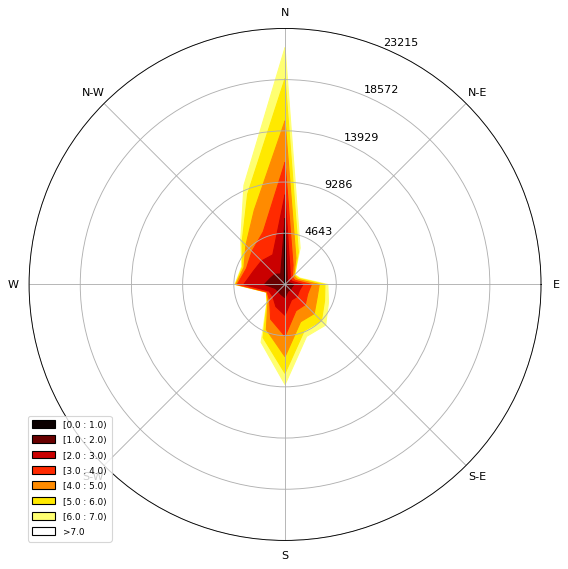

In [23]:
# Criando um gráfico windrose

ax = WindroseAxes.from_ax()
ax.contourf(dataAll['wd'], dataAll['ws'], bins=np.arange(0, 8, 1), cmap=cm.hot)
ax.set_legend()

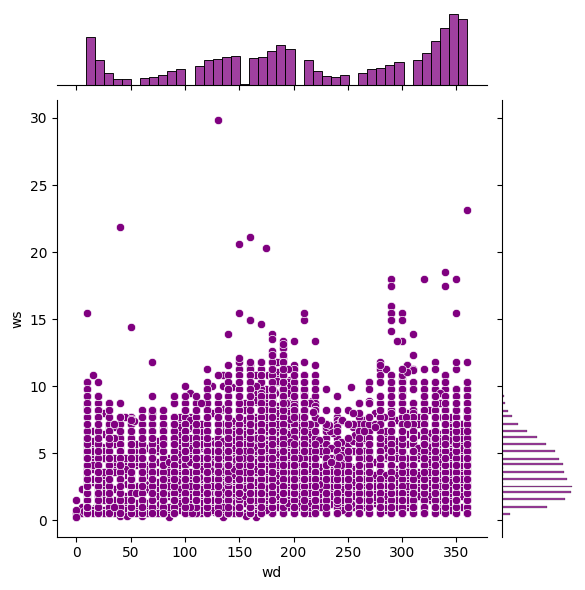

In [24]:
# Criando gráfico jointplto

sns.jointplot(x=df_filtrado.wd,y=df_filtrado.ws,color='purple')

parâmetros da distribuição -> params_10anos=(1, np.float64(2.076920163173546), 0, np.float64(4.286864721775583))


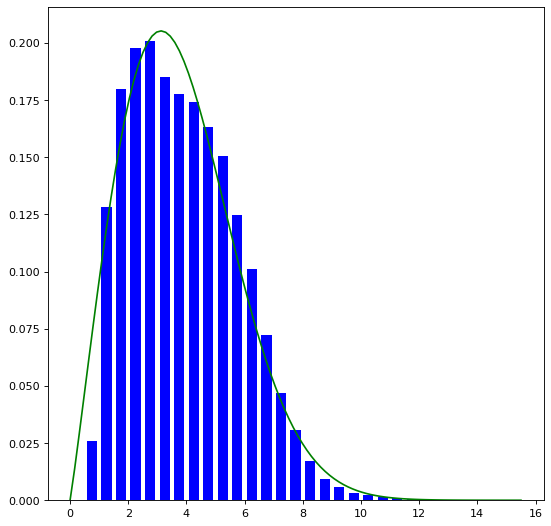

In [25]:
# Ajustando distribuição de Weibull aos dados de 10 anos

ax = WindAxes.from_ax()
bins = np.arange(0, 15 + 1, 0.5)
bins = bins[1:]
ax, params_10anos = ax.pdf(df_filtrado.ws, bins=bins)
print(f"parâmetros da distribuição -> {params_10anos=}")

In [26]:
# Extraindo o ano do índice datetime e adicionando como uma coluna separada
df_filtrado['ano'] = df_filtrado.index.year

# Agrupando por ano e obtendo o valor máximo de 'ws' para cada ano
max_ws_por_ano = df_filtrado.groupby('ano')['ws'].max()

# Exibindo o resultado
print(max_ws_por_ano)

# Convertendo max_ws_por_ano para um DataFrame para facilitar a extração
max_ws_por_ano_df = max_ws_por_ano.reset_index()

# Criando as variáveis ano e ws_max_ano
ano = max_ws_por_ano_df['ano'].values
ws_max_ano = max_ws_por_ano_df['ws'].values

ano

ano
2013    21.863870
2014    23.149980
2015    29.837752
2016    21.092204
2017    15.433320
2018    20.577760
2019    18.005540
2020    18.005540
2021    15.433320
2022    14.404432
2023    18.519984
Name: ws, dtype: float64


array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype=int32)

Parâmetros da distribuição -> params=(1, np.float64(4.64027218351792), 0, np.float64(21.39831979673048))
Poucos dados disponíveis e ajuste ruim


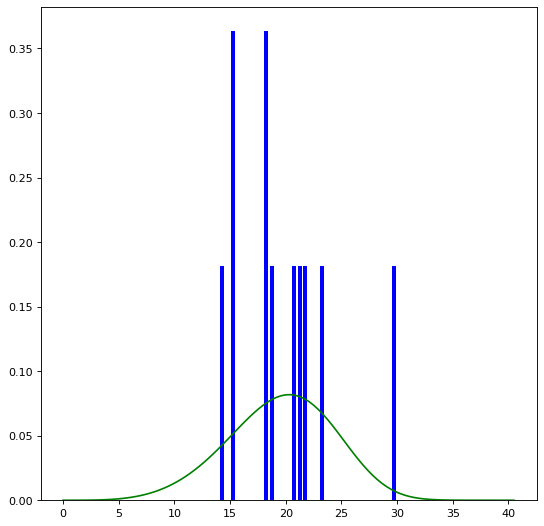

In [27]:
# Criando o gráfico de PDF para as máximas anuais
ax = WindAxes.from_ax()
bins = np.arange(0, 40 + 1, 0.5)
bins = bins[1:]  # Removendo o primeiro valor para evitar o intervalo [0,0.5]

# Calculando a PDF para os dados de velocidade máximos por ano
ax, params = ax.pdf(max_ws_por_ano_df.ws, bins=bins)
print(f"Parâmetros da distribuição -> {params=}")
print("Poucos dados disponíveis e ajuste ruim")

Parâmetros da distribuição -> params=(1, np.float64(2.05055033218193), 0, np.float64(4.071959383732164))


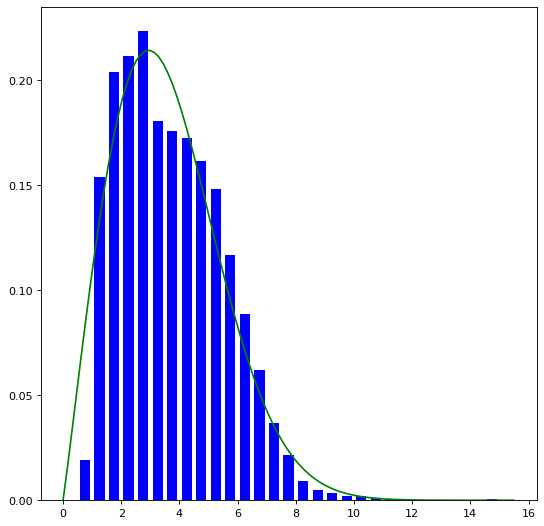

In [28]:
# Filtrando os dados para um ano específico
df_ano = df_filtrado[df_filtrado.index.year == 2015]

# Criando o gráfico de PDF para o ano de 2013
ax = WindAxes.from_ax()
bins = np.arange(0, 15 + 1, 0.5)
bins = bins[1:]  # Removendo o primeiro valor para evitar o intervalo [0,0.5]

# Calculando a PDF para os dados de velocidade do vento em 2013
ax, params = ax.pdf(df_ano.ws, bins=bins)
print(f"Parâmetros da distribuição -> {params=}")

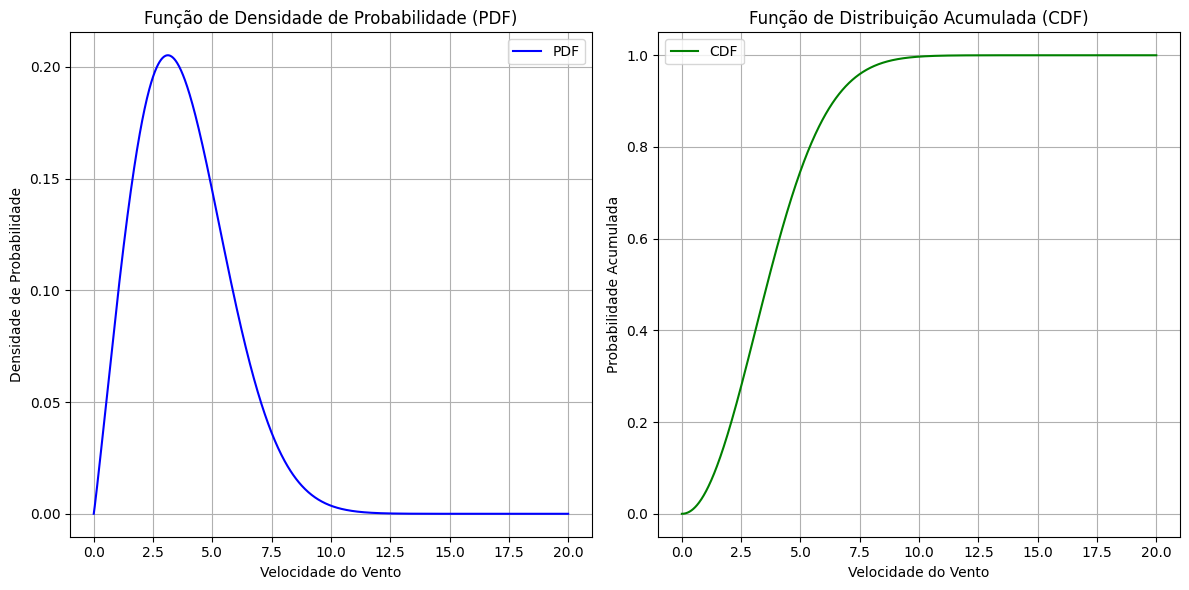

In [29]:
# Parâmetros da distribuição Weibull para os dados de 10 ano
shape = params_10anos[1]  # Parâmetro de forma
loc = params_10anos[2]         # Parâmetro de localização
scale = params_10anos[3]  # Parâmetro de escala

# Gerando valores para o eixo x
x = np.linspace(0, 20, 1000)  # Intervalo para o qual queremos calcular a distribuição

# Calculando a PDF e a CDF da distribuição Weibull
pdf = weibull_min.pdf(x, shape, loc, scale)  # Função de densidade de probabilidade
cdf = weibull_min.cdf(x, shape, loc, scale)  # Função de distribuição acumulada

# Plotando a PDF e a CDF
plt.figure(figsize=(12, 6))

# Gráfico da PDF
plt.subplot(1, 2, 1)
plt.plot(x, pdf, label='PDF', color='blue')
plt.title('Função de Densidade de Probabilidade (PDF)')
plt.xlabel('Velocidade do Vento')
plt.ylabel('Densidade de Probabilidade')
plt.grid(True)
plt.legend()

# Gráfico da CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='CDF', color='green')
plt.title('Função de Distribuição Acumulada (CDF)')
plt.xlabel('Velocidade do Vento')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




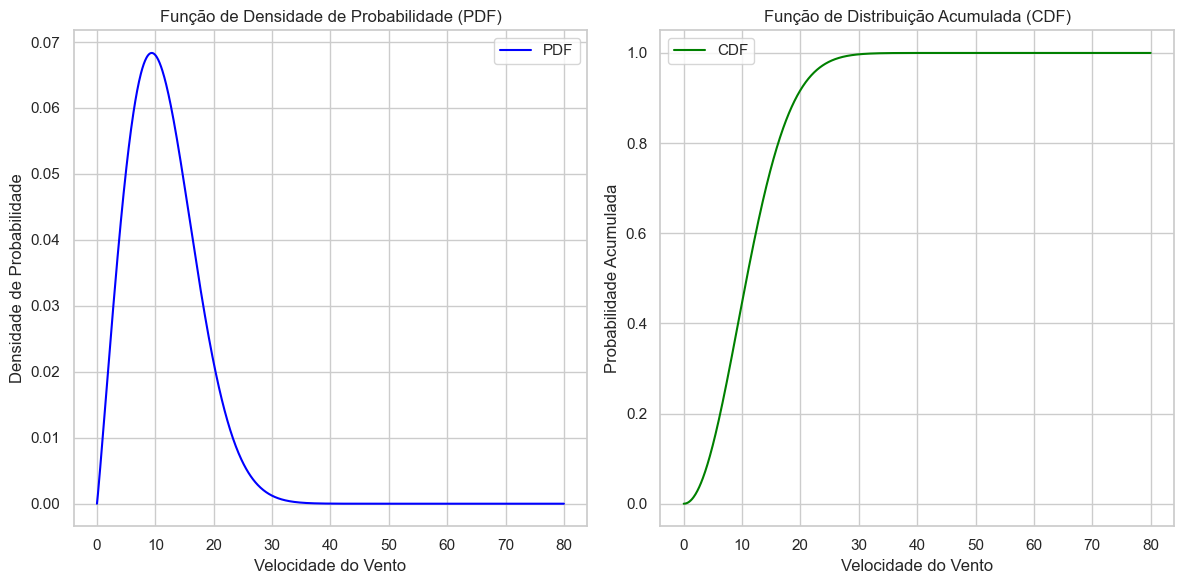

O valor da velocidade de vento de projeto conforme a NBR6123 para Florianópolis é 40 m/s
A velocidade de vento indicada na norma é para uma rajada com ocorrência média de uma vez em 50, TR_50_anos=p_50anos=1/(50*350)=5.47e-3 %
A probabilidade de x = 40 é aproximadamente 0.0000145
O vento característico segundo os dados e a distribuição em questão seria:, v=37.35 m/s, probabilidade=0.0000546


In [53]:
# Distribuição alterada por um fator de escala para consideração de máximos anuais
# Número de observações por período (ex: 365 dias para máximos anuais)
n = 365*50  # ou outro valor dependendo do período de interesse, como 365 * 50 para 50 anos

# Ajuste do parâmetro de escala para a distribuição de extremos (máximos)
scale_max = scale * (np.log(n))**(1/shape)

def weibull_max_pdf(x):
    return (shape / scale_max) * ((x - loc) / scale_max) ** (shape - 1) * np.exp(-((x - loc) / scale_max) ** shape)

# Função de distribuição acumulada (CDF) dos máximos
def weibull_max_cdf(x):
    return 1 - np.exp(-((x - loc) / scale_max) ** shape)

# Valores de x para plotar a distribuição
x = np.linspace(0, 80, 1000)
cdf_max = weibull_max_cdf(x)
pdf_max = weibull_max_pdf(x)

# Plotando a PDF e a CDF
plt.figure(figsize=(12, 6))

# Gráfico da PDF
plt.subplot(1, 2, 1)
plt.plot(x, pdf_max, label='PDF', color='blue')
plt.title('Função de Densidade de Probabilidade (PDF)')
plt.xlabel('Velocidade do Vento')
plt.ylabel('Densidade de Probabilidade')
plt.grid(True)
plt.legend()

# Gráfico da CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf_max, label='CDF', color='green')
plt.title('Função de Distribuição Acumulada (CDF)')
plt.xlabel('Velocidade do Vento')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Exemplo de uso
x_value = 40  # Exemplo de valor de x para o qual queremos calcular a CDF
cdf_value = weibull_max_cdf(x_value)
pdf_value = weibull_max_pdf(x_value)
x_value2 = 37.352
pdf_value2 = weibull_max_pdf(x_value2)
print(f"O valor da velocidade de vento de projeto conforme a NBR6123 para Florianópolis é 40 m/s")
print(f"A velocidade de vento indicada na norma é para uma rajada com ocorrência média de uma vez em 50, TR_50_anos=p_50anos=1/(50*350)=5.47e-3 %")
print(f"A probabilidade de x = {x_value} é aproximadamente {pdf_value:.7f}")
print(f"O vento característico segundo os dados e a distribuição em questão seria:, v={x_value2:.2f} m/s, probabilidade={pdf_value2:.7f}")


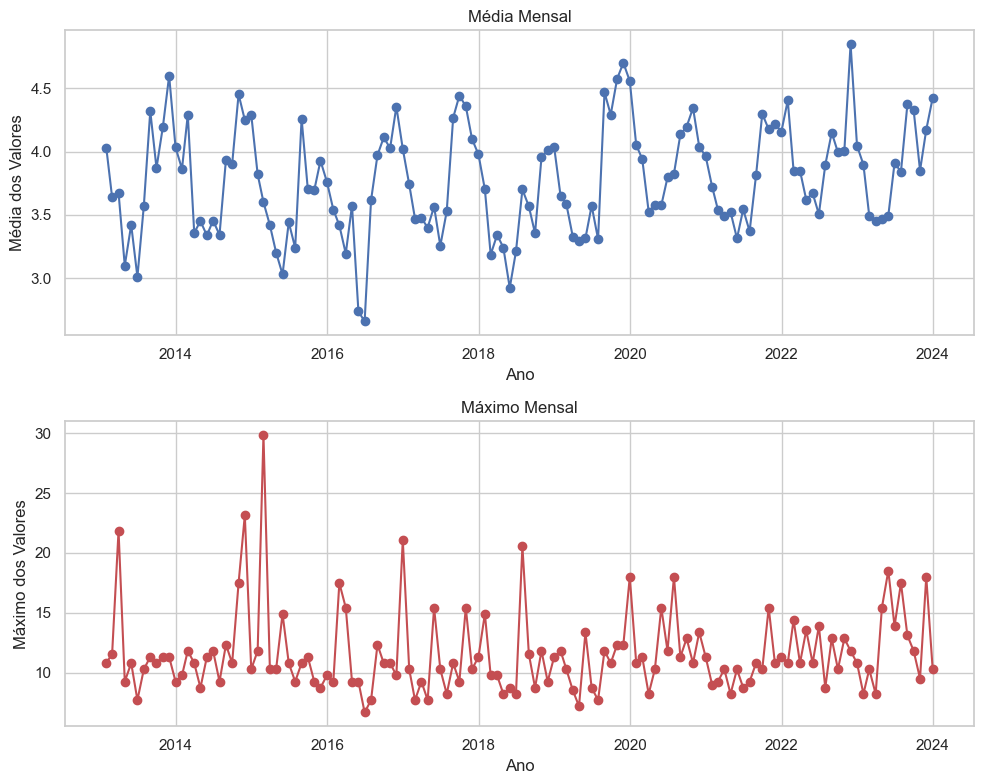

In [31]:
# Configurando o estilo do seaborn
sns.set(style="whitegrid")

# Criando subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico da média mensal
axs[0].plot(media_mensal_ws.index, media_mensal_ws.values, marker='o', color='b')
axs[0].set_title('Média Mensal')
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Média dos Valores')

# Gráfico do máximo mensal
axs[1].plot(maxima_mensal_ws.index, maxima_mensal_ws.values, marker='o', color='r')
axs[1].set_title('Máximo Mensal')
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Máximo dos Valores')

# Ajustando o layout para melhor visualização
plt.tight_layout()
plt.show()

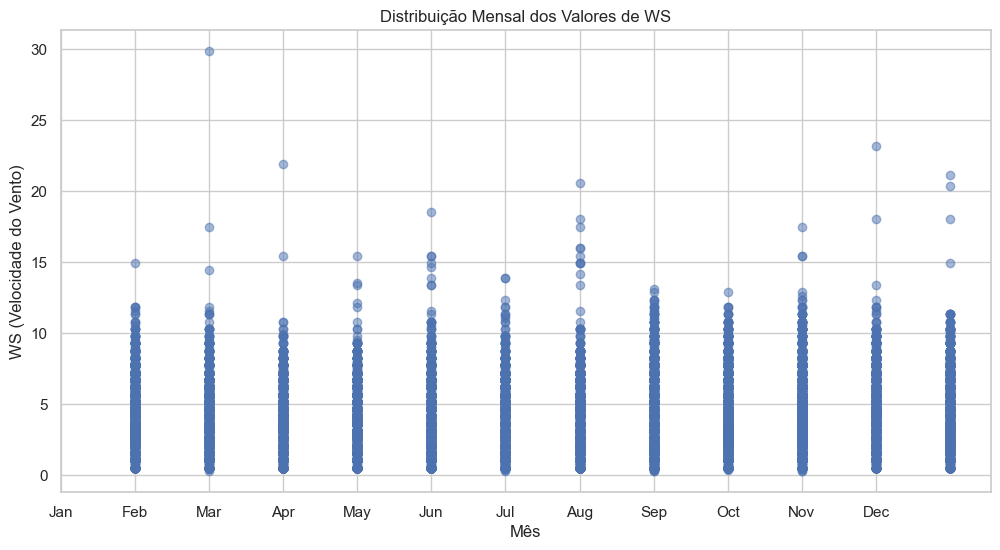

In [32]:
# Extraindo o mês e adicionando como uma coluna separada
df_filtrado['month'] = df_filtrado.index.month

# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.scatter(x=df_filtrado.month, y=df_filtrado.ws, alpha=0.5)

# Configurando rótulos e título
plt.title('Distribuição Mensal dos Valores de WS')
plt.xlabel('Mês')
plt.ylabel('WS (Velocidade do Vento)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Exibindo o gráfico
plt.show()

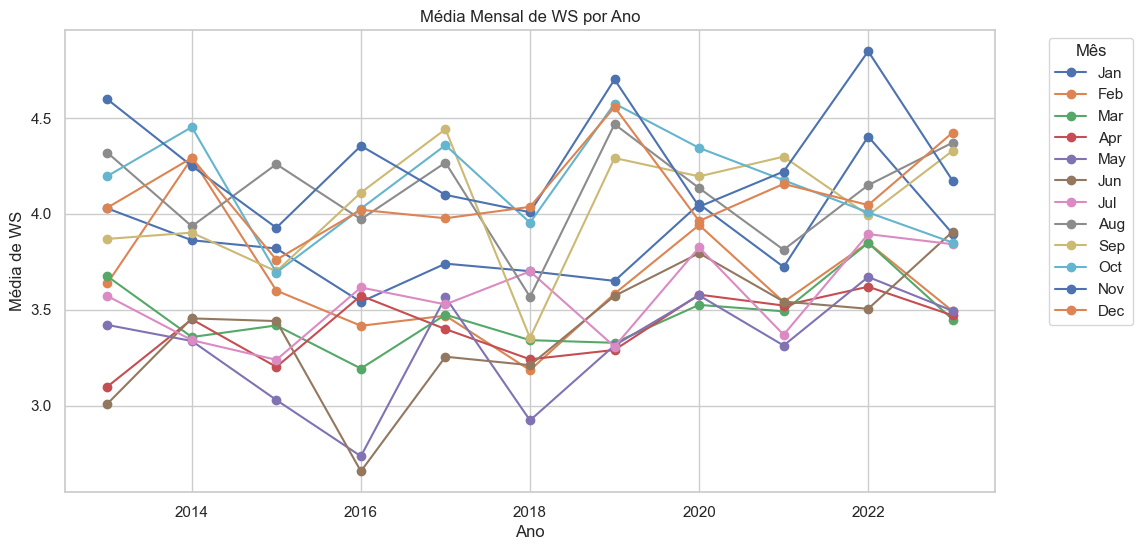

In [33]:
# Média dos meses por ano

# Extraindo o ano e o mês e adicionando como colunas separadas
df_filtrado['ano'] = df_filtrado.index.year
df_filtrado['mes'] = df_filtrado.index.month

# Calculando a média de 'ws' para cada combinação de ano e mês
media_mensal = df_filtrado.groupby(['ano', 'mes'])['ws'].mean().reset_index()

# Plotando o gráfico
plt.figure(figsize=(12, 6))
for mes in range(1, 13):  # Iterando por cada mês
    dados_mes = media_mensal[media_mensal['mes'] == mes]
    plt.plot(dados_mes['ano'], dados_mes['ws'], marker='o', label=f'Mês {mes}' if mes == 1 else "")

# Configurando rótulos e título
plt.title('Média Mensal de WS por Ano')
plt.xlabel('Ano')
plt.ylabel('Média de WS')
plt.legend([f'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], title='Mês', loc='upper left',
    bbox_to_anchor=(1.05, 1) ) # Posição da legenda fora do gráfico)
plt.grid(True)

# Exibindo o gráfico
plt.show()

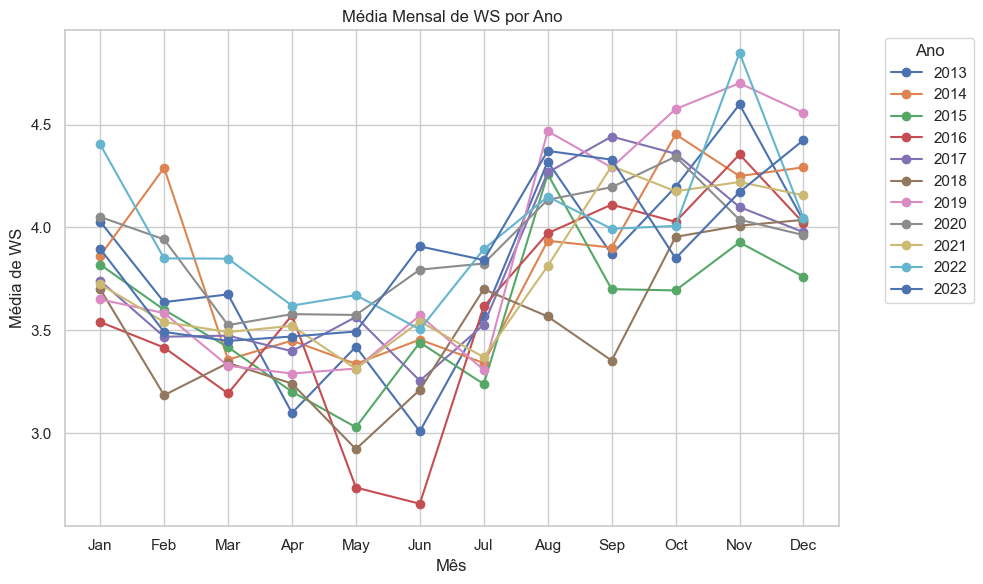

In [34]:
# Média dos meses nos anos por meses

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Iterando sobre cada ano para criar uma linha para cada ano
for ano in media_mensal['ano'].unique():
    dados_ano = media_mensal[media_mensal['ano'] == ano]
    plt.plot(dados_ano['mes'], dados_ano['ws'], marker='o', label=str(ano))

# Configuração de rótulos e título
plt.title('Média Mensal de WS por Ano')
plt.xlabel('Mês')
plt.ylabel('Média de WS')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Posicionando a legenda fora do gráfico
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [35]:
#Teste Mann-Kendall
#Análise de tendência Thiei-sen
#camelsbr

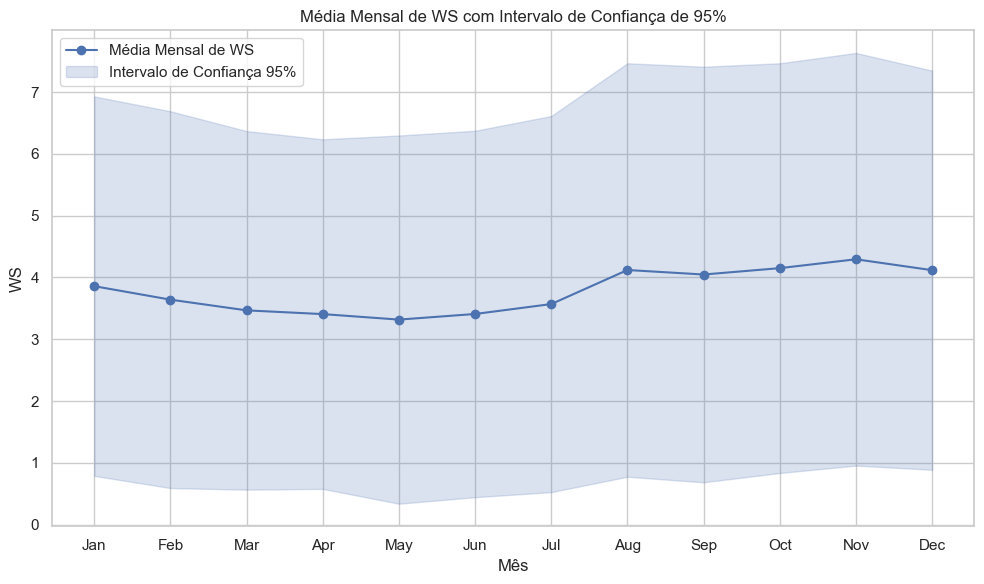

In [36]:
# Extraindo o ano e o mês e adicionando como colunas separadas
df_filtrado['ano'] = df_filtrado.index.year
df_filtrado['mes'] = df_filtrado.index.month

# Calculando a média, o desvio padrão e a contagem de 'ws' para cada combinação de ano e mês
media_mensal = df_filtrado.groupby(['mes'])['ws'].mean()
desvio_da_media_mensal = df_filtrado.groupby(['mes'])['ws'].std()
contagem = df_filtrado.groupby(['mes'])['ws'].count()

# Calculando o intervalo de confiança de 95%
nivel_confianca = 0.9
z = norm.ppf(1 - (1 - nivel_confianca) / 2)  # Valor crítico para 95% de confiança

# Intervalo de confiança
erro_margem = 1.645*desvio_da_media_mensal#z * (desvio_da_media_mensal / np.sqrt(contagem))
ic_inferior = media_mensal - erro_margem
ic_superior = media_mensal + erro_margem

# Plotando o gráfico
plt.figure(figsize=(10, 6))

# Linha da média mensal
plt.plot(media_mensal.index, media_mensal.values, marker='o', color='b', label='Média Mensal de WS')

# Área sombreada para o intervalo de confiança
plt.fill_between(media_mensal.index, ic_inferior, ic_superior, color='b', alpha=0.2, label='Intervalo de Confiança 95%')

# Configuração de rótulos e título
plt.title('Média Mensal de WS com Intervalo de Confiança de 95%')
plt.xlabel('Mês')
plt.ylabel('WS')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


C:\Users\alysson.assis\AppData\Local\Temp\ipykernel_20156\920954187.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados_mensais, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


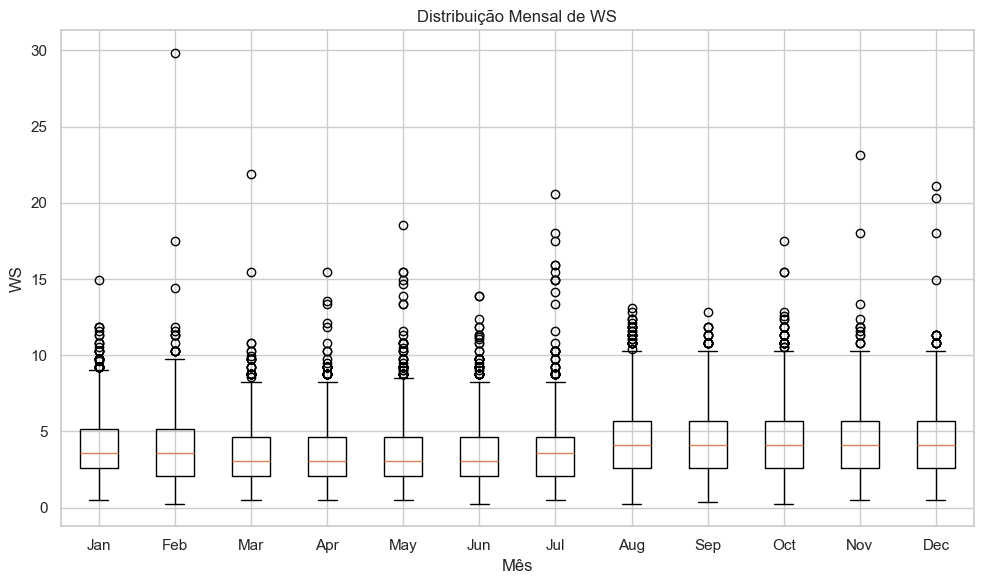

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# Suponha que 'df_filtrado' já está definido e contém a coluna 'ws' com índice datetime
# Extraindo o ano e o mês e adicionando como colunas separadas
df_filtrado['ano'] = df_filtrado.index.year
df_filtrado['mes'] = df_filtrado.index.month

# Agrupando os dados por mês e extraindo listas de 'ws' para cada mês
dados_mensais = [df_filtrado[df_filtrado['mes'] == mes]['ws'] for mes in range(1, 13)]

# Plotando o boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(dados_mensais, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Configuração de rótulos e título
plt.title('Distribuição Mensal de WS')
plt.xlabel('Mês')
plt.ylabel('WS')
plt.grid(True)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


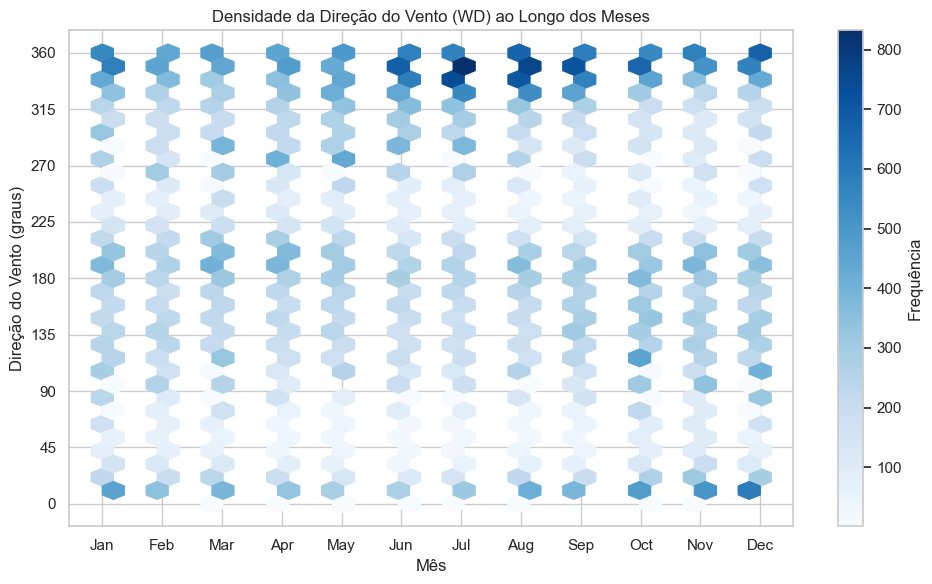

In [38]:
# Criando o gráfico de dispersão com densidade (hexbin) para visualização da frequência das direções em cada mês

plt.figure(figsize=(10, 6))
plt.hexbin(df_filtrado['mes'], df_filtrado['wd'], gridsize=30, cmap='Blues', mincnt=1)  # Escala de cores

# Adicionando uma barra de cores para indicar a frequência
cb = plt.colorbar(label='Frequência')

# Configuração de rótulos e título
plt.title('Densidade da Direção do Vento (WD) ao Longo dos Meses')
plt.xlabel('Mês')
plt.ylabel('Direção do Vento (graus)')

# Configuração de marcações dos eixos
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks(np.arange(0, 361, 45))  # Marcação dos eixos para 0 a 360 graus

# Exibindo o gráfico
plt.tight_layout()
plt.show()


In [39]:
#Teste Mann-Kendall
#Análise de tendência Thiei-sen
#camelsbr